# Regression Coefficients Nullspace Perspective
This notebook contains contains examples and visualizations of the nullspace perspective for regression in high dimensions. 
Corresponding paper: 

Contact: Joachim Schaeffer, joachim.schaeffer@posteo.de

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('./styles/plots.mplstyle')

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_decomposition import PLSRegression

# IPython Libraries
import IPython
import ipywidgets
from ipywidgets import Layout, interact, interactive

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(42)

# Custom functions
import src.basis as basis

from src.nullspace import nullspace_correction
from src.nullspace import plot_nullspace_correction

from src.data_gen import generate_target_values

In [2]:
# Shall plots be saved?
save_plots = True

# Path to save plots
save_plot_path = './../Nullspace/Figures/' 
# save_plot_path = './results/' 

# Plot additional visualizations.
extra_plots = 0

In [3]:
# Helper functions for this notebook

def construct_data(x_min, x_max, basis_function,  
                        mean_params, stdv_params, objtype='data',
                        num_datapoints=50, draws=10, plot_results=False): 
    """Build an object of the basis class based on the passed parameters and return the basis object.

    Parameters
    ----------
    x_min : float 
        Minimum of data range.
    x_max : float
        Maximum of data range.
    basis_function : callable (basis.function)
        Basis function defined in basis.py that it used for generating the data.
    mean_params : ndarray of shape (n_params for basis function)
        Array of means of random paramters that are used by the basis functions.
        The random parameters are drawn from normal distribution.
    stdv_params : ndarray of shape (n_params for basis function)
        Array of standarddeviations of random paramters that are used by the basis functions.
    objtype: str, default='data'
        'data' will initialize from the simple data class, 'mldata' from the mldataclass including an objective y.
    num_datapoints : int, default=50
        Number of linearly spaced datapoints that will range from x_min to x_max
    draws : int, default=10
        Number of draws from basis functions.
    plot_results : bool, default=False
        If True, plot the data matrix. 
        IF False, do not plot.
        
    Returns
    -------
    basis_obj : object
        Initialized object containig the data X.

    Raises
    ------
    ValueError
        If objtype string does not match one of the implemented options. 
    """
    num_basis = len(mean_params)
    x = np.linspace(x_min, x_max, num_datapoints)[:, None]
    if objtype=='data':
        obj = basis.Basis(basis_function, num_basis).Phi(x)
    elif objtype=='mldata':
        obj = basis.SynMLData(basis_function, num_basis).Phi(x)
    else:
        ValueError(f'You entered {objtype}, which does not correspond to an implemented option.')

    # Draw the parameters for the matrix
    # m = np.random.uniform(low=range_m[0], high=range_m[1], size=rows)
    param_vals = np.zeros((draws, len(mean_params)))
    for i,(j,k) in enumerate(zip(mean_params, stdv_params)):
        param_vals[:, i] = np.array([np.random.normal(loc=j, scale=k) for p in range(draws)])

    # Construct it
    obj = obj.construct_X_data(param_vals)
    if plot_results:
        # Plot it# Construct it
        plt.plot(x, obj.X.T)
        plt.title('Data Generated from Basis Function')
        plt.show()

    return obj

def construct_plot_data_interactive(x_min, x_max, basis_function,  
                        mean_param0, mean_param1, mean_param2, 
                        stdv_params0, stdv_params1, stdv_params2, 
                        num_datapoints=50, draws=10):
    """Wraper around 'construct_plot_data' to interact with ipython widget
    """
    mean_params = np.array([mean_param0, mean_param1, mean_param2])     
    stdv_params = np.array([stdv_params0, stdv_params1, stdv_params2])   

    basis_obj = construct_data(x_min, x_max, basis_function,  
                        mean_params, stdv_params,
                        num_datapoints=num_datapoints, draws=draws, plot_results=1)
    return None  

def nullspace_correction_wrap(w_alpha, w_beta, data_ml_obj, std=False):
    """Function that calls 'nullspace_correction allowing to shorten syntax and use SynMLData class.

    Parameters
    ----------
    w_alpha : ndarray
        Regression coefficients obtained with method alpha
    w_beta : ndarray
        Regression coefficients obtained with method beta
    data_ml_obj : obj 
        Object from SynMLData class
    std : bool, default=False
        Indicate whether Standardization(Z-Scoring) shall be performed. 
        If yes, use X_std of the data_ml_object, if not use X.
    
    Returns
    -------
    see 'nullspace_correction'
    """
    if std: 
        X = data_ml_obj.X_std
    else: 
        X = data_ml_obj.X_
    x = data_ml_obj.x

    y_ = data_ml_linear_n.y_
    y_range = np.max(y_) - np.min(y_)
    min_exp = -5
    max_exp = np.floor(np.log10(int((10**2)*y_range)))
    gs  = np.logspace(min_exp, max_exp, 30)
    gs = np.append(gs, [int((10**2)*y_range)])
    return nullspace_correction(w_alpha, w_beta, X, x, gs=gs, comp_block=0, snig=0)

#### Example of basis function usage!

In [4]:
if 0:
    x_min = -np.pi/4
    x_max = +np.pi/4

    # Random parameter values based on normal distributed values
    means = [1, 1, 0.5, 0.1, 0.1]
    stdv = [2, 2, 0.2, 0.1, 0.1]
    # Draw the parameters for the matrix
    # m = np.random.uniform(low=range_m[0], high=range_m[1], size=rows)

    basis_obj = construct_data(x_min, x_max, basis.polynomial, means, stdv,
                               num_datapoints=50, draws=10, plot_results=1)

In [5]:
slider_length = '85%'

interactive(construct_plot_data_interactive,
        basis_function = ipywidgets.Dropdown(
                                options=[(basis.fourier), (basis.polynomial), (basis.relu)],
                                value=(basis.polynomial),
                                description='Function Basis'),
        x_min = ipywidgets.FloatSlider(
                                value=-2,
                                min=-10,
                                max=10,
                                step=0.00001,
                                layout = Layout(width=slider_length),
                                description='X_min',
                                continuous_update=False),
        x_max = ipywidgets.FloatSlider(
                                value=5,
                                min=-10,
                                max=10,
                                step=0.00001,
                                layout = Layout(width=slider_length),
                                description='X_max',
                                continuous_update=False),
        mean_param0 = ipywidgets.FloatSlider(
                                value=0,
                                min=0,
                                max=10,
                                step=0.00001,
                                layout = Layout(width=slider_length),
                                description='mean_0',
                                continuous_update=False),
        mean_param1 = ipywidgets.FloatSlider(
                                value=1,
                                min=0,
                                max=7,
                                step=0.00001,
                                layout = Layout(width=slider_length),
                                description='mean_1',
                                continuous_update=False),
        mean_param2 = ipywidgets.FloatSlider(
                                value=1,
                                min=0,
                                max=4,
                                step=0.00001,
                                layout = Layout(width=slider_length),
                                description='mean_2',
                                continuous_update=False),
        stdv_params0 = ipywidgets.FloatSlider(
                                value=0,
                                min=0,
                                max=7,
                                step=0.00001,
                                layout = Layout(width=slider_length),
                                description='std_0',
                                continuous_update=False),
        stdv_params1 = ipywidgets.FloatSlider(
                                value=1,
                                min=0,
                                max=7,
                                step=0.00001,
                                layout = Layout(width=slider_length),
                                description='std_1',
                                continuous_update=False),
        stdv_params2 = ipywidgets.FloatSlider(
                                value=1,
                                min=0,
                                max=7,
                                step=0.00001,
                                layout = Layout(width=slider_length),
                                description='std_2',
                                continuous_update=False),
        num_datapoints = ipywidgets.IntSlider(
                                value=50,
                                min=10,
                                max=200,
                                layout = Layout(width=slider_length),
                                description='cols',
                                continuous_update=False),
        draws = ipywidgets.IntSlider(
                                value=50,
                                min=1,
                                max=200,
                                layout = Layout(width=slider_length),
                                description='draws',
                                continuous_update=False)
        )

interactive(children=(FloatSlider(value=-2.0, continuous_update=False, description='X_min', layout=Layout(widt…

#### Generate Synthethic
Showcase of the Nullspace methodology on different examples.

Generate Synthethic dataset, using SynMLData class that inherits form the basis class. 

Example I: Linear basis function

In [6]:
means = [0, 0.2]
stdv = [0, 0.15]
x_min = 1
x_max = 5

# Data without noise.
data_ml_linear = construct_data(
    x_min, x_max, basis.polynomial, means, stdv, objtype='mldata', num_datapoints=200, draws=50, plot_results=0)

# Data with noise.
data_ml_linear_n = construct_data(
    x_min, x_max, basis.polynomial, means, stdv, objtype='mldata', num_datapoints=200, draws=50, plot_results=0).add_wgn(40)

# Example Case I: 
# The true feature is the mean.
mean_function = lambda a : np.mean(a, axis=1)
mean_reg_coef = (1/data_ml_linear.X.shape[1]) * np.ones(data_ml_linear.X.shape[1])

data_ml_linear = data_ml_linear.construct_y_data(mean_function)
data_ml_linear_n = data_ml_linear_n.construct_y_data(mean_function)

# Machine Learning models that are used to compare regression coefficients. 
# The hyperparameters are chosen conservatively here to showcase the method. 
# Alternatively, use cross validation.
model_PLS1 = PLSRegression(n_components=1, tol=1e-7, scale=False)
model_rr0p3 = Ridge(alpha=0.3)

# Learn the weights (aka regression coefficients), using the models defined above.
data_ml_linear = data_ml_linear.learn_weights(model_PLS1, 'PLS 1 Comp.')
data_ml_linear = data_ml_linear.learn_weights(model_rr0p3, 'RR lambda 0.3')

data_ml_linear_n = data_ml_linear_n.learn_weights(model_PLS1, 'PLS 1 Comp.')
data_ml_linear_n = data_ml_linear_n.learn_weights(model_rr0p3, 'RR lambda 0.3')

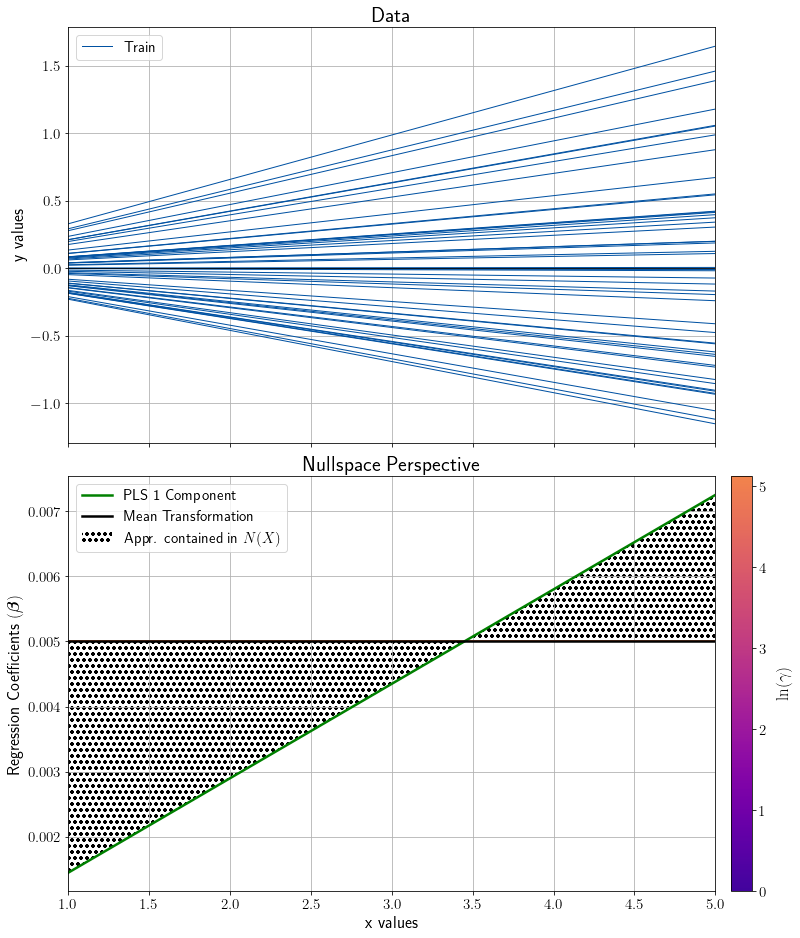

FileNotFoundError: [Errno 2] No such file or directory: './../OverleafNullspace/Figures/Linear_example.pdf'

In [7]:
data_ml_linear = data_ml_linear.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef, w_beta_name='Mean Transformation', std=False)

fig, ax = data_ml_linear.plot_nullspace_correction()

if save_plots:
    fig.savefig(save_plot_path + 'Linear_example.pdf')

In [ ]:
# Visualize standardized data.
if extra_plots: 
    plt.plot(data_ml_linear.x, data_ml_linear.X_std.T)
    plt.title('Data Standardized')
    plt.show()

In [ ]:
# Visualize regression coefficients for the standardized data. 
if extra_plots: 
    plt.plot(data_ml_linear.x, data_ml_linear.weights['PLS 1 Comp. std'], label='Reg Std')
    plt.plot(data_ml_linear.x, mean_reg_coef*data_ml_linear.std, label='Mean std_trans')
    plt.legend()
    plt.show()
    # Conclusion: Coefficients on standardized might lead to more realistic shapes because they are not affected by the nullspace. 
    # However, retransforming them into to 'non' standardized case will makee it more difficutl to interpret them because a combination of standard deviation and regularization will lead ot coefficients that might not be very useful!
    # It should be shown on other examples that this preliminary assumption holds true. 

In [ ]:
# Visualize regression coefficients for the standardized data retransformed to make predictions with the origianl data.
if extra_plots:
    plt.plot(data_ml_linear.x, data_ml_linear.weights['PLS 1 Comp. std']/data_ml_linear.std, label='Std retrans') 
    plt.plot(data_ml_linear.x, data_ml_linear.weights['PLS 1 Comp.'], label='No std')
    plt.plot(data_ml_linear.x, mean_reg_coef, label='Mean')
    plt.legend()

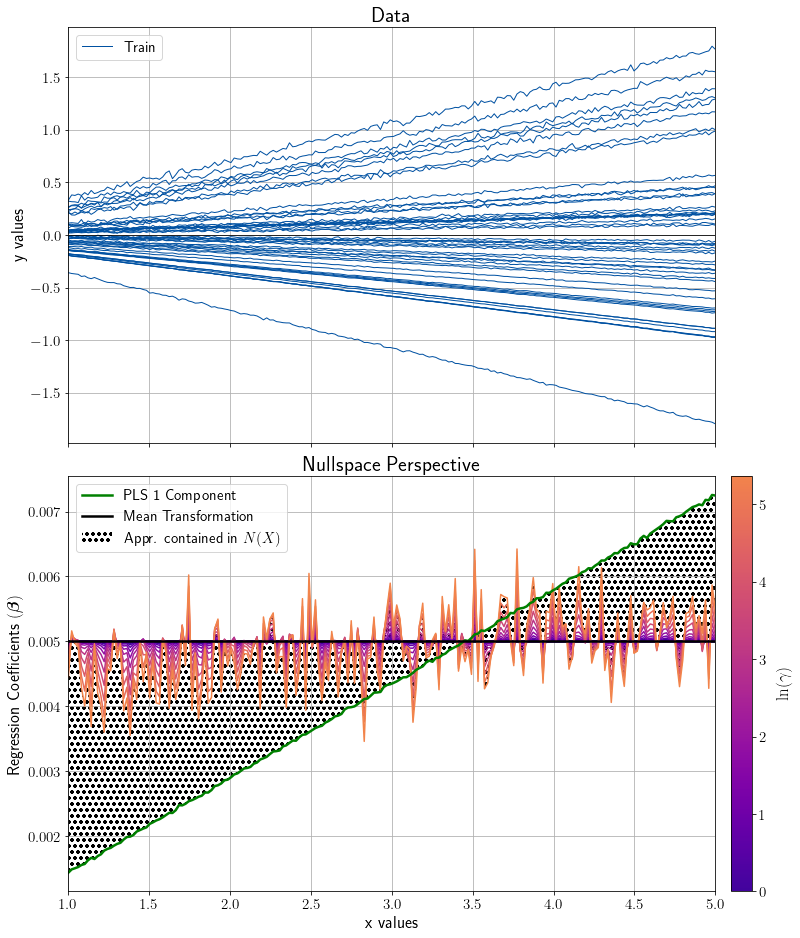

In [ ]:
data_ml_linear_n = data_ml_linear_n.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef, w_beta_name='Mean Transformation', std=False)

fig, ax = data_ml_linear_n.plot_nullspace_correction()

if save_plots:
    fig.savefig(save_plot_path + 'Linear_example_noise.pdf')

Example II: Parabolas

In [ ]:
x_min = 1
x_max = 3.0
means = [0, 0, 0.3]
stdv = [0, 0, 0.3]
x = np.linspace(x_min, x_max, 200)[:, None]

# Data without noise
data_ml_parab = construct_data(
    x_min, x_max, basis.polynomial, means, stdv, objtype='mldata', num_datapoints=200, draws=50, plot_results=0)

# Data with noise
data_ml_parab_n = construct_data(
    x_min, x_max, basis.polynomial, means, stdv, objtype='mldata', num_datapoints=200, draws=50, plot_results=0).add_wgn(40)

# True feature is the mean
mean_function = lambda a : np.mean(a, axis=1)
mean_reg_coef = (1/data_ml_parab.X.shape[1]) * np.ones(data_ml_parab.X.shape[1])

data_ml_parab = data_ml_parab.construct_y_data(mean_function)
data_ml_parab_n = data_ml_parab_n.construct_y_data(mean_function)

# Learn the weights (aka regression coefficients), using the models defined above.
data_ml_parab = data_ml_parab.learn_weights(model_PLS1, 'PLS 1 Comp.')
data_ml_parab = data_ml_parab.learn_weights(model_rr0p3, 'RR lambda 0.3')

data_ml_parab_n = data_ml_parab_n.learn_weights(model_PLS1, 'PLS 1 Comp.')
data_ml_parab_n = data_ml_parab_n.learn_weights(model_rr0p3, 'RR lambda 0.3')

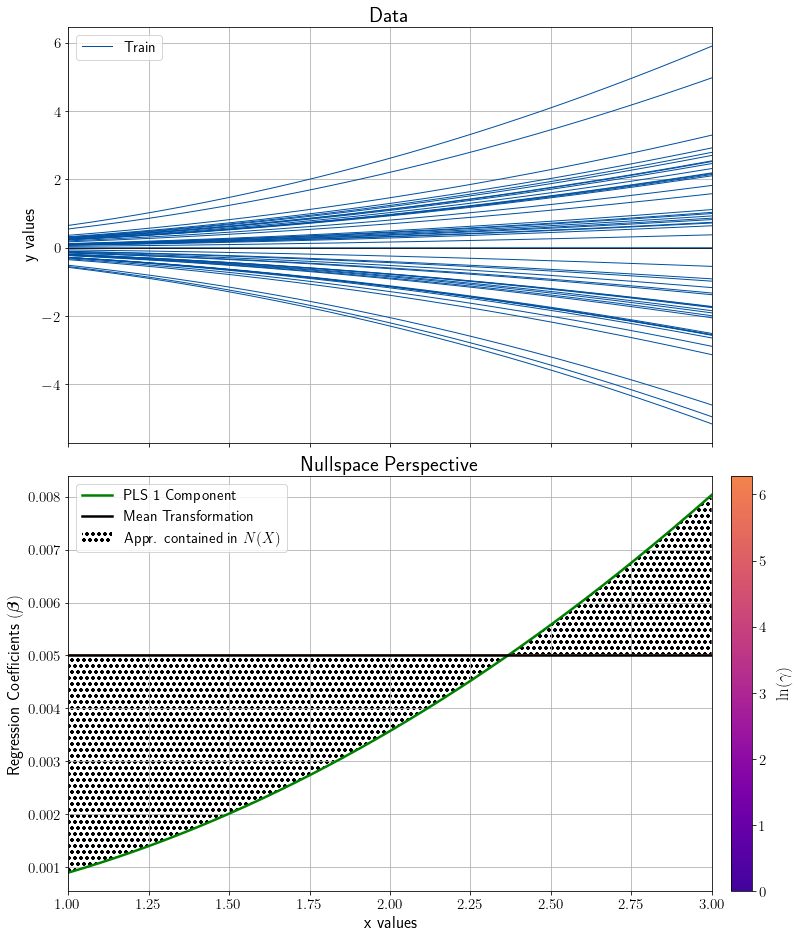

In [ ]:
data_ml_parab = data_ml_parab.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef, w_beta_name='Mean Transformation', std=False)

fig, ax = data_ml_parab.plot_nullspace_correction()
# ax[1].plot(data_ml_parab.x, data_ml_parab.weights_std['PLS 1 Comp. std'])
# ax[1].plot(data_ml_parab.x, data_ml_parab.weights_std_retrans['PLS 1 Comp. std retrans'])

if save_plots:
    fig.savefig(save_plot_path + 'Polynomial_example.pdf')

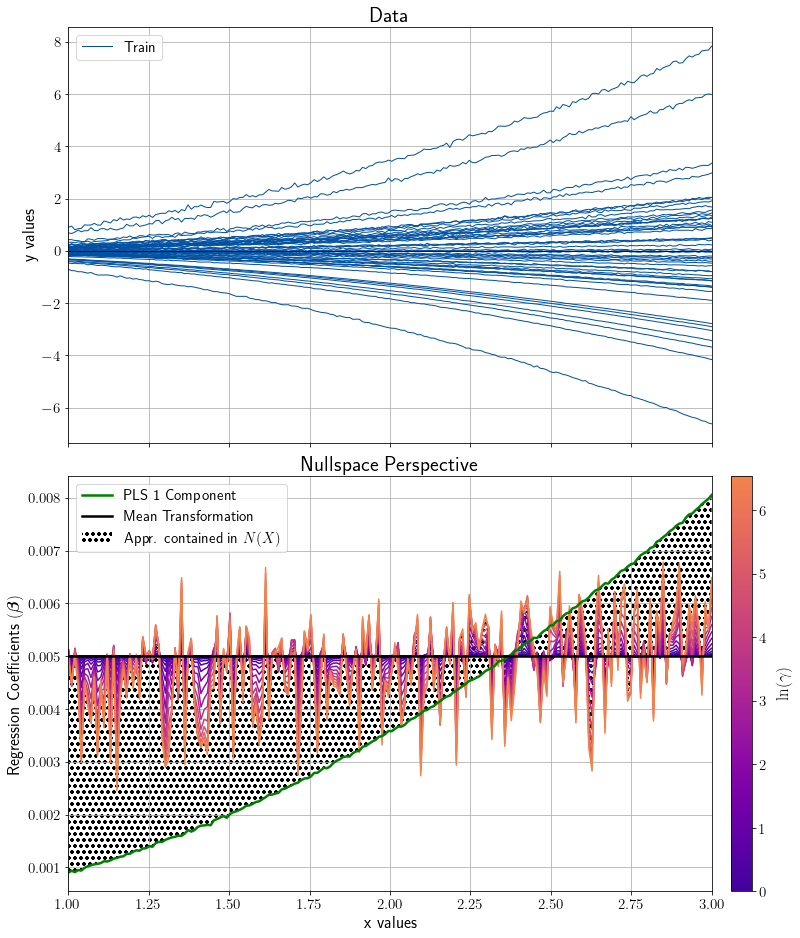

In [ ]:
data_ml_parab_n = data_ml_parab_n.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef, w_beta_name='Mean Transformation', std=False)

fig, ax = data_ml_parab_n.plot_nullspace_correction()
# ax[1].plot(data_ml_parab.x, data_ml_parab.weights_std['PLS 1 Comp. std'])
# ax[1].plot(data_ml_parab.x, data_ml_parab.weights_std_retrans['PLS 1 Comp. std retrans'])

if save_plots:
    fig.savefig(save_plot_path + 'Polynomial_example_noise.pdf')

Example from LAVADE:

More details about this test case in the publication:

LATENT VARIABLE METHOD DEMONSTRATOR - SOFTWARE FOR UNDERSTANDING MULTIVARIATE DATA ANALYTICS ALGORITHMS

https://arxiv.org/pdf/2205.08132.pdf

In [ ]:
# Method translated from MATLAB code
# https://github.com/JoachimSchaeffer/LAVADE

# Parameters
means = np.array([2, -1, -4, -5])
stds = np.array([0, 2, 2, 0])

samples = 60
measurement_points = 150
points_left = 60
points_middle = 30 
point_right = measurement_points-points_left-points_middle

start_value = np.random.normal(means[0], stds[0], samples)
target_left = np.random.normal(means[1], stds[1], samples)
target_right = np.random.normal(means[2], stds[2], samples)
final_value = np.random.normal(means[3], stds[3], samples)

rand_uc_l = np.zeros((samples, points_left))
rand_uc_r = np.zeros((samples, point_right))
signal = np.zeros((samples, points_middle))

# Algorithm from LAVADE
for i in range(samples):
    rand_uc_l[i, :] = np.linspace(start_value[i], target_left[i], points_left)
    rand_uc_r[i, :] = np.linspace(target_right[i], final_value[i], point_right)
    signal[i, :] =  np.linspace(target_left[i], target_right[i], points_middle)

# Build the datamatrix X
X_lavade = np.hstack((rand_uc_l[:, :-1], signal, rand_uc_r[:, 1:]))
x_lavade = np.linspace(0, measurement_points-3, measurement_points-2)
y_lavade = (target_right-target_left)/points_middle

# Contruct data object
data_ml_LAVADE_ex = basis.SynMLData(None, None)
data_ml_LAVADE_ex = data_ml_LAVADE_ex.place_X_y(X_lavade, x_lavade, y_lavade)

# Another way:
# y_lavade = lambda X : (X[:, points_left+points_middle-2]-X[:, points_left-1])/points_middle
# y_lavade = lambda X : (X[:, 60+30-2]-X[:, 60-1])/30

In [ ]:
if extra_plots:
    plt.plot(x_lavade, X_lavade.T)
    plt.title('LAVADE Example')
    plt.xlabel('x values ()')
    plt.ylabel('y values ()')
    plt.show()

In [ ]:
# Compare RR and lasso
model_PLS2 = PLSRegression(n_components=2, tol=1e-7, scale=False)
model_PLS3 = PLSRegression(n_components=3, tol=1e-7, scale=False)
model_PLS4 = PLSRegression(n_components=4, tol=1e-7, scale=False)
model_rr_lavade = Ridge(alpha=10**(-6))
model_lasso_lavade = Lasso(alpha=0.015)

data_ml_LAVADE_ex = data_ml_LAVADE_ex.learn_weights(model_PLS2, 'PLS 2 Comp.')
data_ml_LAVADE_ex = data_ml_LAVADE_ex.learn_weights(model_rr_lavade, 'RR lambda 10e-6')
data_ml_LAVADE_ex = data_ml_LAVADE_ex.learn_weights(model_lasso_lavade, 'lasso lambda 0.015')

/Users/joachim/Documents/PhD/PhD_Material/02Research/Papers/02Nullspace/HDFeat/src/basis.py:145: RuntimeWarning: invalid value encountered in true_divide
  self.X_std = self.X_ / self.std
/Users/joachim/Documents/PhD/PhD_Material/02Research/Papers/02Nullspace/HDFeat/src/basis.py:145: RuntimeWarning: invalid value encountered in true_divide
  self.X_std = self.X_ / self.std
/Users/joachim/Documents/PhD/PhD_Material/02Research/Papers/02Nullspace/HDFeat/src/basis.py:145: RuntimeWarning: invalid value encountered in true_divide
  self.X_std = self.X_ / self.std


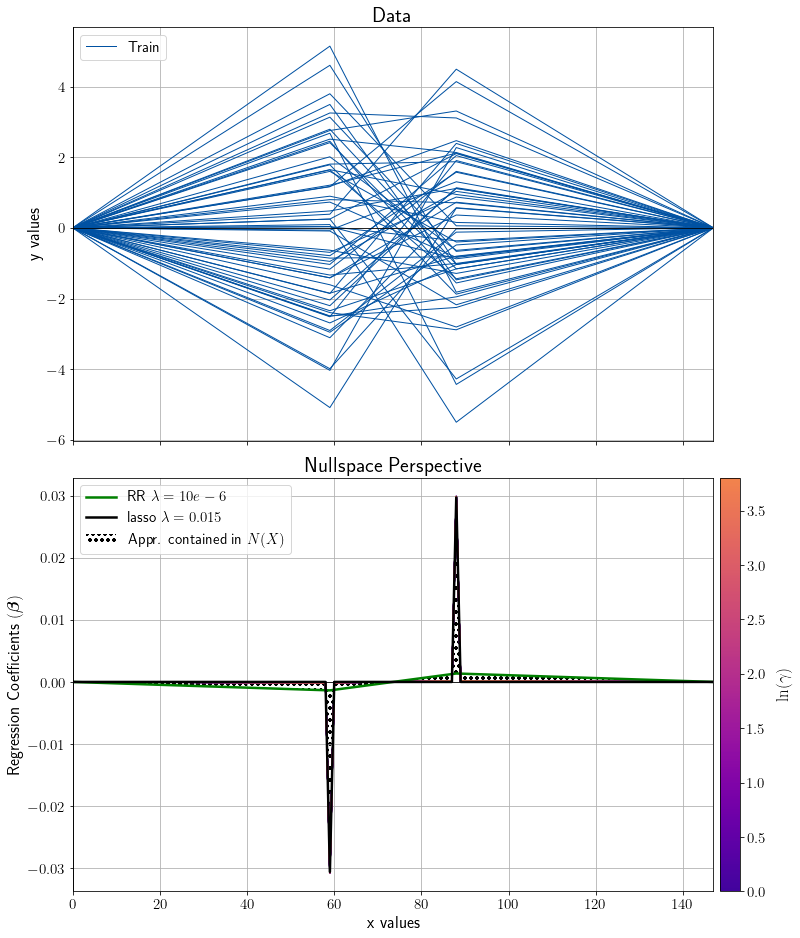

In [ ]:
data_ml_LAVADE_ex = data_ml_LAVADE_ex.nullspace_correction(
    key_alpha = 'RR lambda 10e-6', w_alpha_name=r'RR $\lambda=10e-6$', 
    key_beta = 'lasso lambda 0.015', w_beta_name=r'lasso $\lambda=0.015$', std=False)

fig, ax = data_ml_LAVADE_ex.plot_nullspace_correction()
# ax[1].plot(data_ml_parab.x, data_ml_parab.weights_std['PLS 1 Comp. std'])
# ax[1].plot(data_ml_parab.x, data_ml_parab.weights_std_retrans['PLS 1 Comp. std retrans'])

if save_plots:
    fig.savefig(save_plot_path + 'LAVADE_example.pdf')

Example using LFP Data:

published with:
Data-driven prediction of battery cycle life before capacity degradation

https://www.nature.com/articles/s41560-019-0356-8

Source of data: 
https://data.matr.io/

License of LFP data: lfpdatalicense.txt

In [ ]:
# Load the LFP Dataset
lfp_df = pd.read_csv('lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])    
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

y_lfp_train_syn = np.zeros(X_lfp_train.shape[0])
mean_function = lambda a: np.mean(a)
mean_reg_coef_lfp = (1/X_lfp_train.shape[1]) * np.ones(X_lfp_train.shape[1])

y_lfp_train_syn = generate_target_values(X_lfp_train[:, :], mean_function, percentage_range_x_to_t=[0,1])

# Contruct data object
data_ml_lfp_syn = basis.SynMLData(None, None).place_X_y(X_lfp_train, x_lfp, y_lfp_train_syn)
data_ml_lfp_true = basis.SynMLData(None, None).place_X_y(X_lfp_train, x_lfp, y_lfp_train_true)

In [ ]:
# LFP dataset synthethic y
data_ml_lfp_syn = data_ml_lfp_syn.learn_weights(model_PLS1, 'PLS 1 Comp.')
data_ml_lfp_syn = data_ml_lfp_syn.learn_weights(model_PLS2, 'PLS 2 Comp.')
data_ml_lfp_syn = data_ml_lfp_syn.learn_weights(model_PLS3, 'PLS 3 Comp.')
data_ml_lfp_syn = data_ml_lfp_syn.learn_weights(model_PLS4, 'PLS 4 Comp.')

# LFP dataset true y
data_ml_lfp_true = data_ml_lfp_true.learn_weights(model_PLS1, 'PLS 1 Comp.')
data_ml_lfp_true = data_ml_lfp_true.learn_weights(model_PLS2, 'PLS 2 Comp.')
data_ml_lfp_true = data_ml_lfp_true.learn_weights(model_PLS3, 'PLS 3 Comp.')
data_ml_lfp_true = data_ml_lfp_true.learn_weights(model_PLS4, 'PLS 4 Comp.')

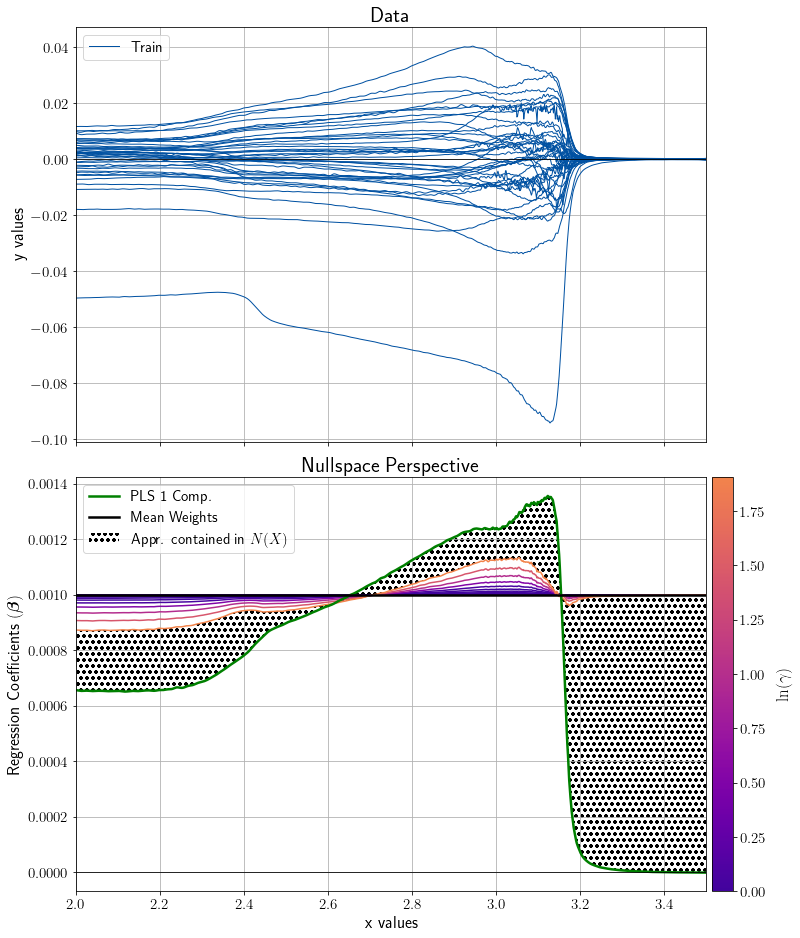

In [ ]:
data_ml_lfp_syn = data_ml_lfp_syn.nullspace_correction(
    key_alpha ='PLS 1 Comp.', w_alpha_name='PLS 1 Comp.', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=False)
    
fig, ax = data_ml_lfp_syn.plot_nullspace_correction()
# ax[1].plot(data_ml_parab.x, data_ml_parab.weights_std['PLS 1 Comp. std'])
# ax[1].plot(data_ml_parab.x, data_ml_parab.weights_std_retrans['PLS 1 Comp. std retrans'])

if save_plots:
    fig.savefig(save_plot_path + 'LAVADE_example.pdf')

In [ ]:
from sklearn.metrics import mean_squared_error

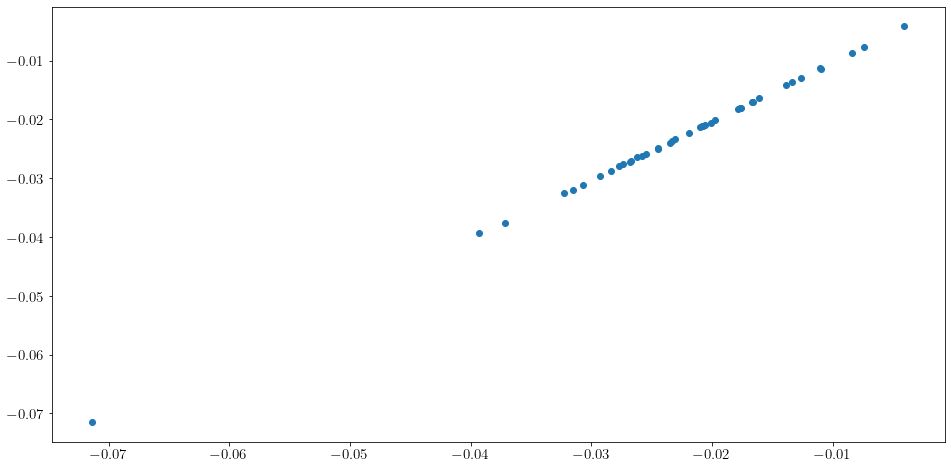

In [ ]:
plt.scatter(data_ml_lfp_syn.X@mean_reg_coef_lfp, data_ml_lfp_syn.X@data_ml_lfp_syn.weights['PLS 1 Comp.']+data_ml_lfp_syn.X@data_ml_lfp_syn.nullsp['v_'][-1, :])

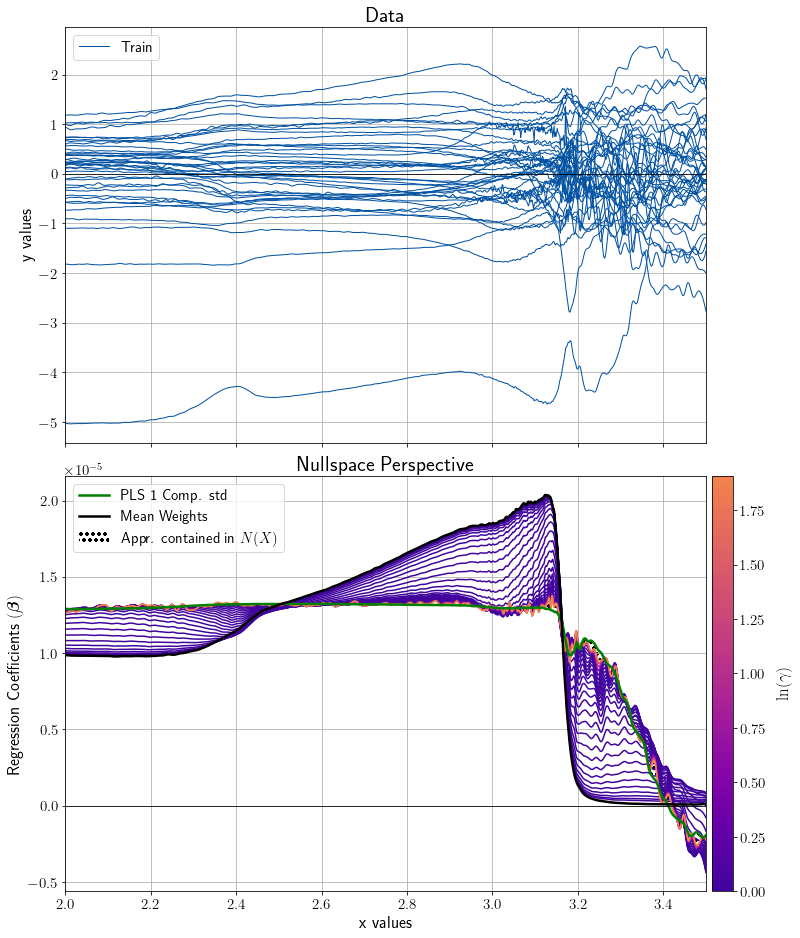

In [ ]:
data_ml_lfp_syn = data_ml_lfp_syn.nullspace_correction(
    key_alpha ='PLS 1 Comp. std', w_alpha_name='PLS 1 Comp. std', 
    w_beta = mean_reg_coef_lfp*data_ml_lfp_syn.std, w_beta_name='Mean Weights', std=True)
    
fig, ax = data_ml_lfp_syn.plot_nullspace_correction(std=True)
# ax[1].plot(data_ml_parab.x, data_ml_parab.weights_std['PLS 1 Comp. std'])
# ax[1].plot(data_ml_parab.x, data_ml_parab.weights_std_retrans['PLS 1 Comp. std retrans'])

if save_plots:
    fig.savefig(save_plot_path + 'LFP_example_std_1PLS_mean.pdf')

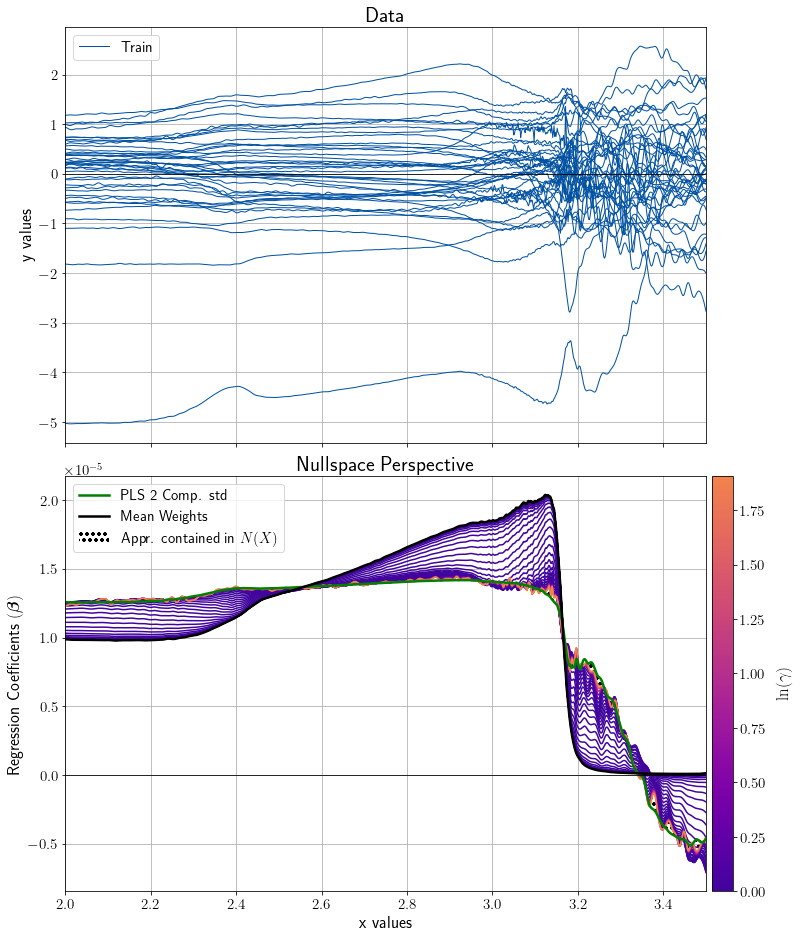

In [ ]:
data_ml_lfp_syn = data_ml_lfp_syn.nullspace_correction(
    key_alpha ='PLS 2 Comp. std', w_alpha_name='PLS 2 Comp. std', 
    w_beta = mean_reg_coef_lfp*data_ml_lfp_syn.std, w_beta_name='Mean Weights', std=True)
    
fig, ax = data_ml_lfp_syn.plot_nullspace_correction(std=True)

if save_plots:
    fig.savefig(save_plot_path + 'LFP_example_std_2PLS_mean.pdf')

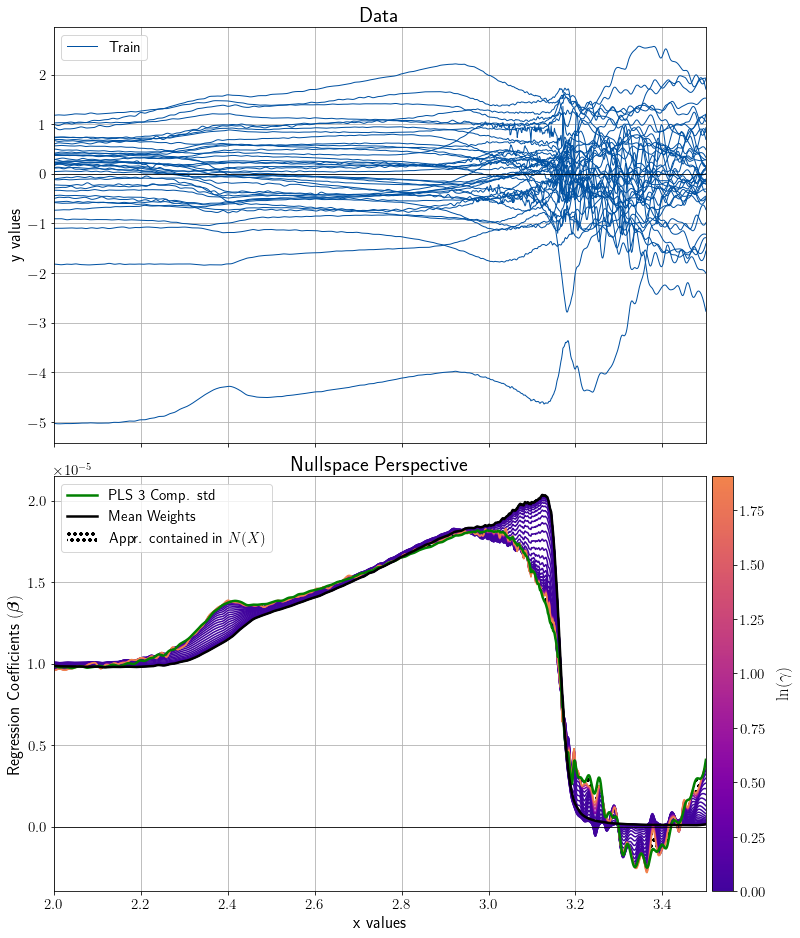

In [ ]:
data_ml_lfp_syn = data_ml_lfp_syn.nullspace_correction(
    key_alpha ='PLS 3 Comp. std', w_alpha_name='PLS 3 Comp. std', 
    w_beta = mean_reg_coef_lfp*data_ml_lfp_syn.std, w_beta_name='Mean Weights', std=True)
    
fig, ax = data_ml_lfp_syn.plot_nullspace_correction(std=True)

if save_plots:
    fig.savefig(save_plot_path + 'LFP_example_std_3PLS_mean.pdf')


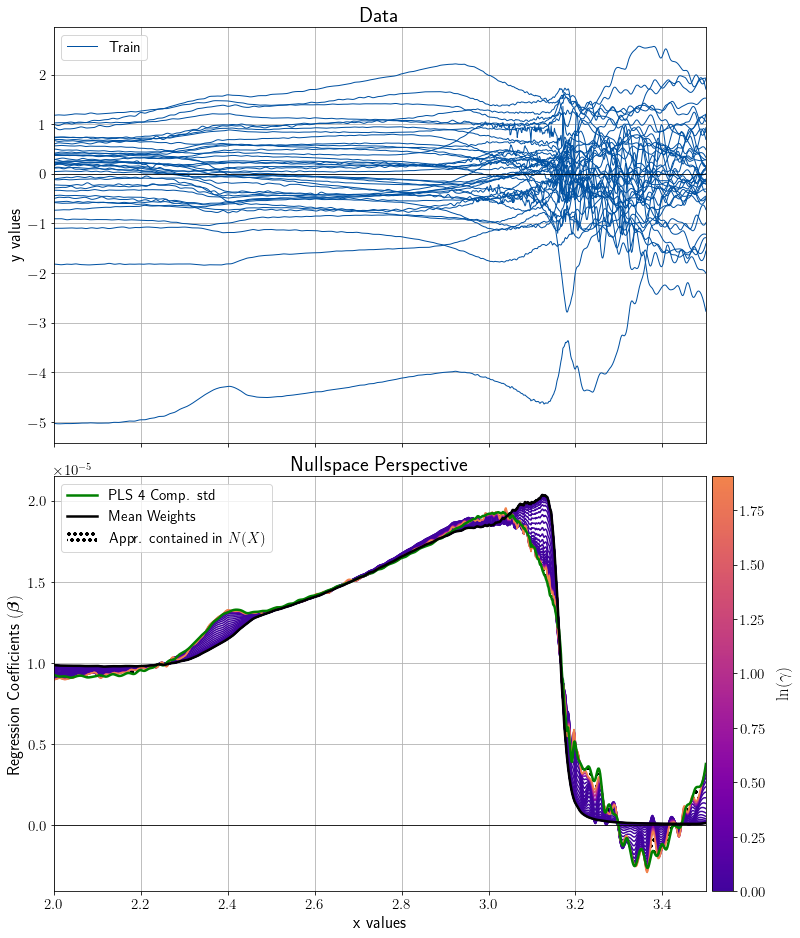

In [ ]:
data_ml_lfp_syn = data_ml_lfp_syn.nullspace_correction(
    key_alpha ='PLS 4 Comp. std', w_alpha_name='PLS 4 Comp. std', 
    w_beta = mean_reg_coef_lfp*data_ml_lfp_syn.std, w_beta_name='Mean Weights', std=True)
    
fig, ax = data_ml_lfp_syn.plot_nullspace_correction(std=True)

if save_plots:
    fig.savefig(save_plot_path + 'LFP_example_std_4PLS_mean.pdf')

In [ ]:
if extra_plots:
    plt.plot(data_ml_lfp_syn.x, data_ml_lfp_syn.weights['PLS 1 Comp. std'], label='PLS1, X_std')
    plt.plot(data_ml_lfp_syn.x, mean_reg_coef_lfp*data_ml_lfp_syn.std, label='Mean weights*std')
    plt.ylabel('Voltage (V)')
    plt.xlabel('Regression Coefficients')
    plt.legend()
    plt.show()

{y: a0 + a1*cos(w*x) + a2*cos(2*w*x) + a3*cos(3*w*x) + b1*sin(w*x) + b2*sin(2*w*x) + b3*sin(3*w*x)}

Parameter Value        Standard Deviation
a0        5.000000e-01 2.075395e-02
a1        5.734936e-12 3.277426e-02
a2        6.124944e-12 3.197889e-02
a3        3.243902e-12 3.080979e-02
b1        6.267589e-01 2.548585e-02
b2        1.986491e-02 2.643438e-02
b3        1.846406e-01 2.756060e-02
w         8.671471e-01 3.356602e-02
Status message         Optimization terminated successfully.
Number of iterations   25
Objective              <symfit.core.objectives.LeastSquares object at 0x7fe8d356f400>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7fe8d356f4c0>

Goodness of fit qualifiers:
chi_squared            0.7478591086418305
objective_value        0.37392955432091524
r_squared              0.9401712713086535


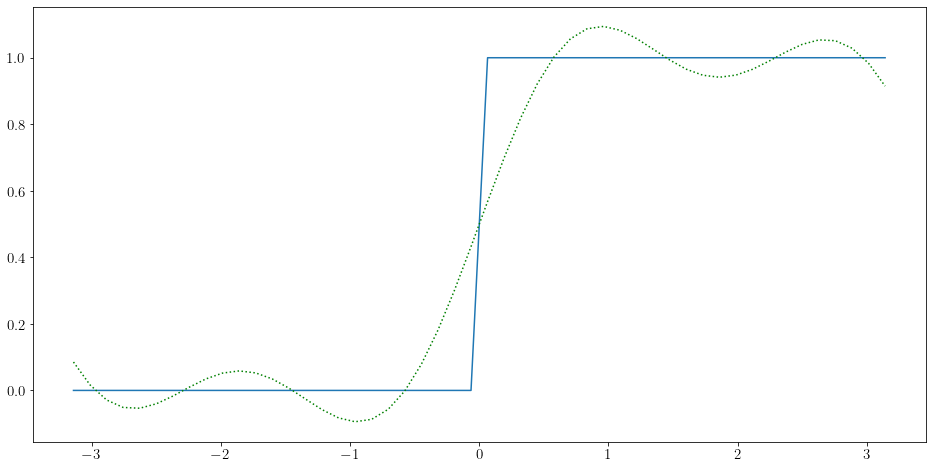

In [ ]:
# From https://stackoverflow.com/questions/52524919/fourier-series-fit-in-python

# This lets you fit parameters to your data
# Ths could be nice to figure out what type of function might fir certain data well 
# In particular we could make an effort to fit "functions" to the DeltaQ feature,
# Estimate the disributions of their parameters and subsequently sample from those distributions

from symfit import parameters, variables, sin, cos, Fit
import numpy as np
import matplotlib.pyplot as plt

def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

x, y = variables('x, y')
w, = parameters('w')
model_dict = {y: fourier_series(x, f=w, n=3)}
print(model_dict)

# Make step function data
xdata = np.linspace(-np.pi, np.pi)
ydata = np.zeros_like(xdata)
ydata[xdata > 0] = 1
# Define a Fit object for this model and data
fit = Fit(model_dict, x=xdata, y=ydata)
fit_result = fit.execute()
print(fit_result)

# Plot the result
plt.plot(xdata, ydata)
plt.plot(xdata, fit.model(x=xdata, **fit_result.params).y, color='green', ls=':')